In [181]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import statsmodels.api as sm
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller

In [182]:
dataPaths = glob.glob("./*.csv")
dataDict = {}
delta = 0.5
time = pd.read_csv(dataPaths[-1], header=None)
for data in dataPaths[:-1]:
    temp = pd.read_csv(data, header=None)
    temp.set_index(time.values.squeeze(), inplace=True)
    dataDict[data[2:].split(".")[0]] = temp

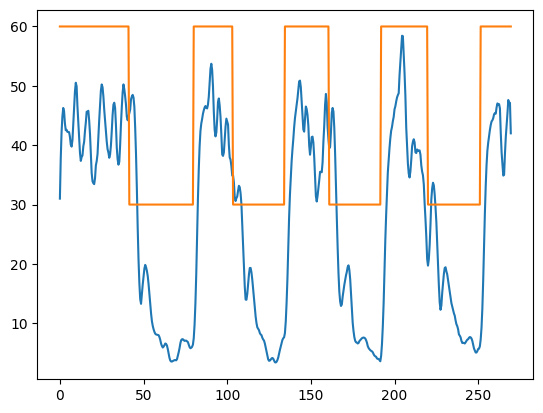

In [183]:
plt.plot(dataDict["S1_f"])
plt.plot(dataDict["gate1"])
plt.show()

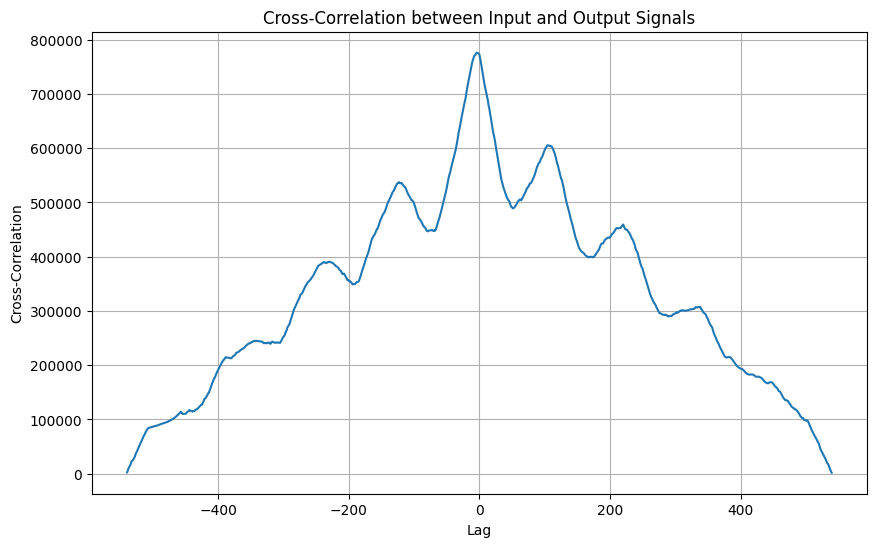

In [184]:
input = dataDict["S1"].values.squeeze(1)
output = dataDict["gate1"].values.squeeze(1)

crossCorrelation = np.correlate(output, input, mode='full')

lags = np.arange(-(len(input) - 1), len(output))

# Plot the cross-correlation
plt.figure(figsize=(10, 6))
plt.plot(lags, crossCorrelation, label='Cross-Correlation')
plt.xlabel('Lag')
plt.ylabel('Cross-Correlation')
plt.title('Cross-Correlation between Input and Output Signals')
plt.grid(True)
plt.show()


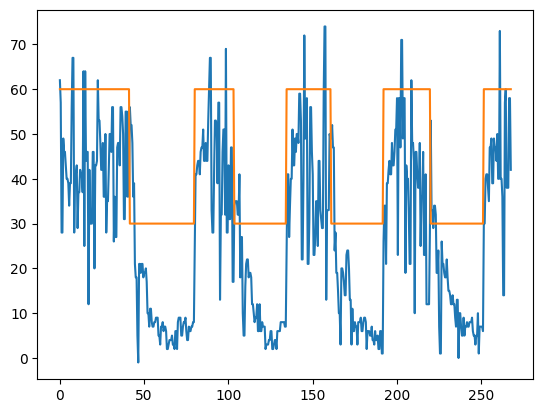

In [185]:
plt.plot(dataDict["S1"].shift(-4))
plt.plot(dataDict["gate1"].iloc[:-4])
plt.show()

In [186]:
shift = np.argmin(np.abs(lags))- np.argmax(crossCorrelation)
shift

4

In [187]:
dataDict["S1"] = dataDict["S1"].iloc[shift:]
dataDict["gate1"] = dataDict["gate1"].shift(shift).dropna()

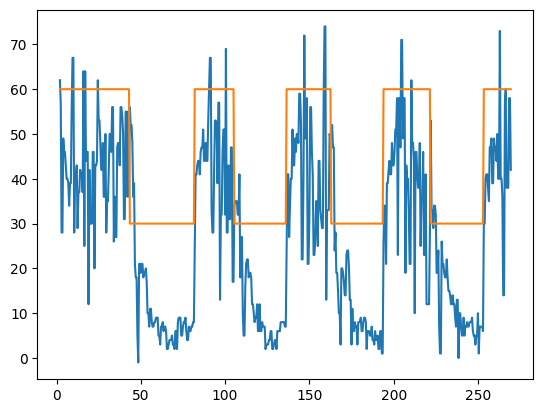

In [188]:
plt.plot(dataDict["S1"])
plt.plot(dataDict["gate1"])
plt.show()

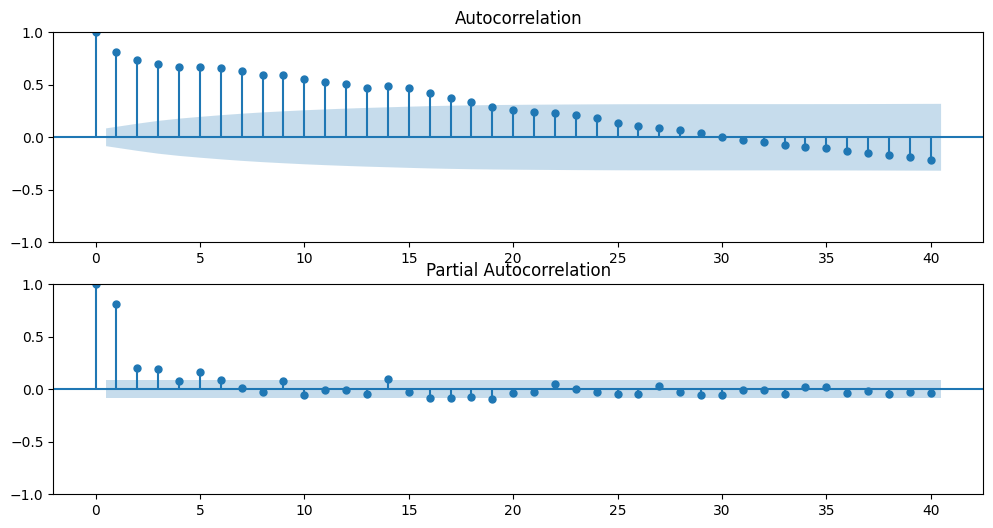

0.003950621813185675


In [189]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
sm.graphics.tsa.plot_acf(dataDict["S1"], lags=40, ax=ax1)
sm.graphics.tsa.plot_pacf(dataDict["S1"], lags=40, ax=ax2)
plt.show()


adftest = adfuller(dataDict["S1"])
print(adftest[1])

In [190]:
pm.auto_arima(dataDict["S1"],dataDict["gate1"])

ARIMA(order=(2, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [241]:
model = sm.tsa.ARIMA(dataDict["S1"], exog=dataDict["gate1"], order=(2,0,0))
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      0   No. Observations:                  536
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -2008.557
Date:                Thu, 02 Nov 2023   AIC                           4027.115
Time:                        02:48:12   BIC                           4048.536
Sample:                             0   HQIC                          4035.495
                                - 536                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.8815      2.908     -3.742      0.000     -16.580      -5.183
0              0.8426      0.053     16.002      0.000       0.739       0.946
ar.L1          0.4957      0.037     13.502      0.0

C:\Users\Alihan\anaconda3\envs\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Alihan\anaconda3\envs\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Alihan\anaconda3\envs\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [237]:
results.params

const     -10.881451
0           0.842601
ar.L1       0.495668
ar.L2       0.071672
sigma2    105.224774
dtype: float64

C:\Users\Alihan\anaconda3\envs\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


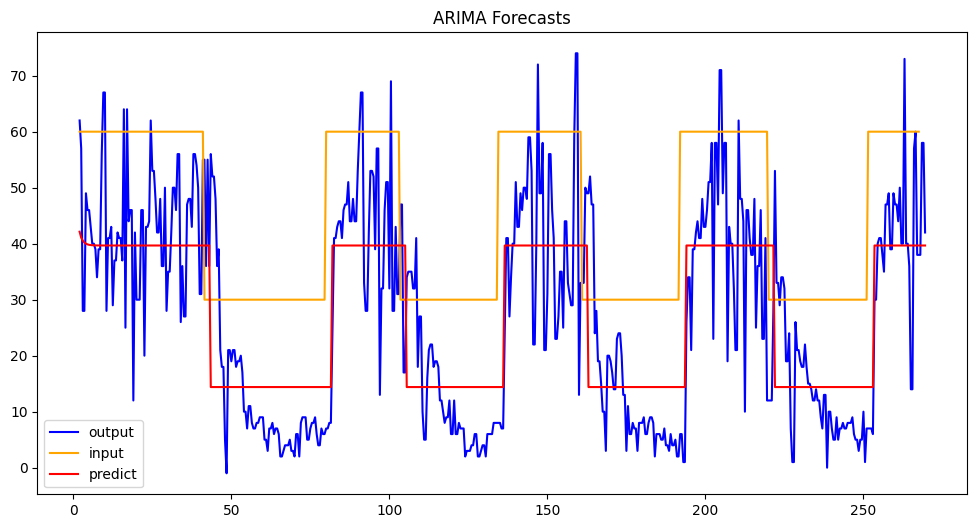

In [209]:
# forecast = results.predict(start=i, exog=dataDict["gate1"], end=j, dynamic=False)
forecast = results.forecast(len(dataDict["gate1"]), exog=dataDict["gate1"])

plt.figure(figsize=(12, 6))
plt.plot(dataDict["S1"], label='output', color='blue')
plt.plot(dataDict["gate1"].shift(-4), label='input', color='orange')
plt.plot(time.iloc[shift:].values.squeeze(), forecast, label='predict', color='red')
plt.legend()
plt.title('ARIMA Forecasts')
plt.show()


In [275]:
output = np.zeros_like(dataDict["gate1"].values.squeeze())
input = dataDict["gate1"].values.squeeze()

const =    -10.881451
b1    =      0.842601
arL1 =     0.495668
arL2 =      0.071672
sigma2=    105.224774

for i in range(6, len(output)):
    output[i] = const + b1*input[i] + arL1*output[i-5] + arL2*output[i-6] - 10 # + np.random.normal(0, 10)

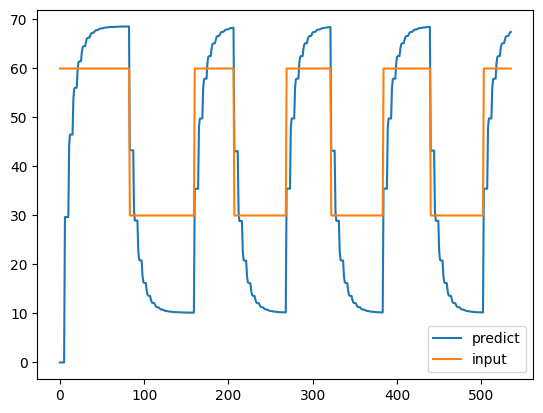

In [276]:
plt.plot(output, label="predict")
plt.plot(input, label="input")
plt.legend()
plt.show()

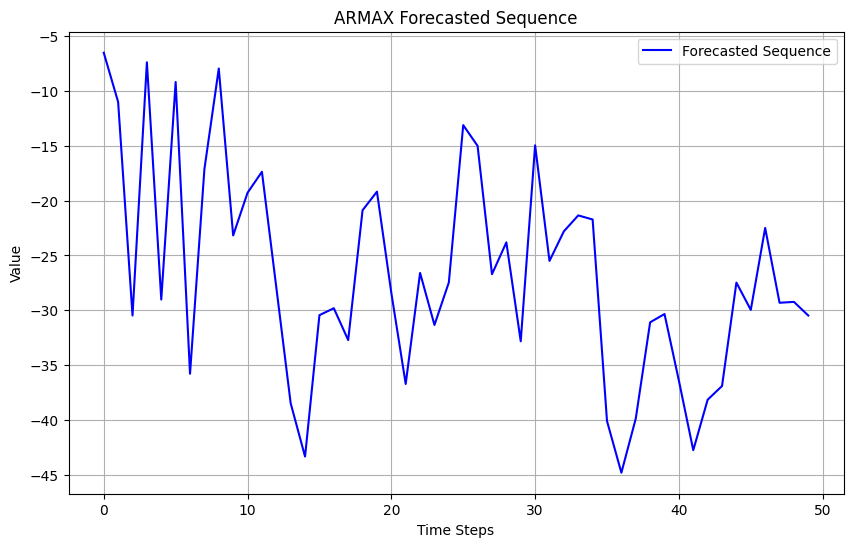

In [277]:
import numpy as np
import matplotlib.pyplot as plt

def forecast_armax(const, variable, ar_params, sigma2, n_forecast_steps):
    # Generate random white noise for forecasting
    white_noise = np.random.normal(0, np.sqrt(sigma2), n_forecast_steps)

    # Initialize the forecasted time series with zeros
    forecasted_series = np.zeros(n_forecast_steps)

    # Perform forecasting
    for t in range(n_forecast_steps):
        ar_term = 0
        for i in range(len(ar_params)):
            if t - i - 1 >= 0:
                ar_term += ar_params[i] * forecasted_series[t - i - 1]
        forecasted_series[t] = const + variable * white_noise[t] + ar_term

    return forecasted_series

# Example parameters
const = -10.881451
variable = 0.842601
ar_params = [0.495668, 0.071672]
sigma2 = 105.224774
n_forecast_steps = 50  # Number of steps to forecast

# Generate the forecasted sequence
forecasted_sequence = forecast_armax(const, variable, ar_params, sigma2, n_forecast_steps)

# Plot the forecasted sequence
plt.figure(figsize=(10, 6))
plt.plot(forecasted_sequence, label='Forecasted Sequence', color='blue')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('ARMAX Forecasted Sequence')
plt.legend()
plt.grid(True)
plt.show()


In [273]:
i = 1
j = len(dataDict["gate1"])//2-i

forecast = results.predict(start=i,exog=dataDict["gate1"].iloc[i:j], end=j, dynamic=False, typ='levels')

plt.figure(figsize=(12, 6))
plt.plot(dataDict["t"], dataDict["S1_f"], label='output', color='blue')
plt.plot(dataDict["t"], dataDict["gate1"], label='input', color='orange')
plt.plot(np.arange(i, j+1, 1), forecast, label='predict', color='red')
plt.legend()
plt.title('ARIMA Forecasts')
plt.xlabel('Tarih')
plt.ylabel('Y Değişkeni')
plt.show()


KeyError: 't'

<Figure size 1200x600 with 0 Axes>

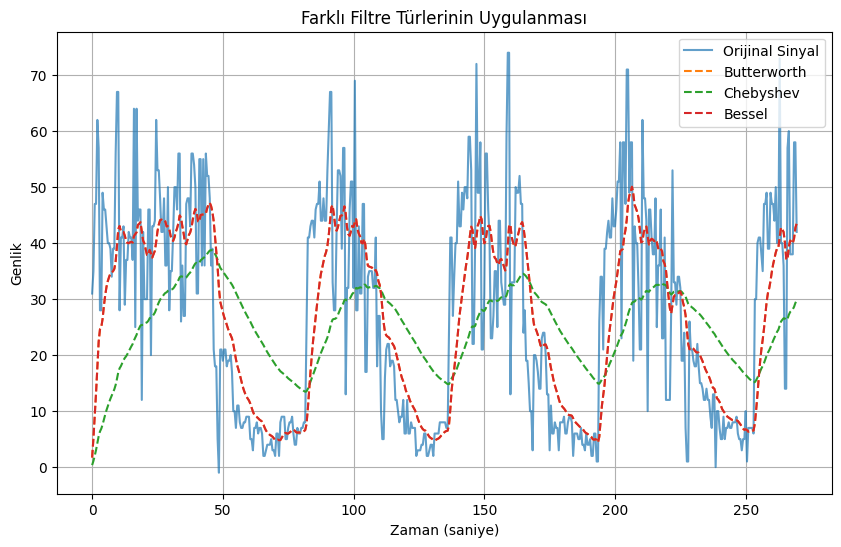

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Giriş sinyali oluşturun
fs = len(dataDict["S1"].values.squeeze())  # Örnekleme frekansı (Hz)
t = dataDict["t"].values.squeeze()  # Zaman aralığı
input_signal = dataDict["S1"].values.squeeze()

# Farklı filtre türlerini uygulayın
butterworth_filter = signal.butter(1, 10, 'low', analog=False, fs=fs)
chebyshev_filter = signal.cheby1(1, 10, 6, 'low', analog=False, fs=fs)
bessel_filter = signal.bessel(1, 10, 'low', analog=False, fs=fs)

output_butterworth = signal.lfilter(*butterworth_filter, input_signal)
output_chebyshev = signal.lfilter(*chebyshev_filter, input_signal)
output_bessel = signal.lfilter(*bessel_filter, input_signal)

# Sonuçları grafikle görselleştirin
plt.figure(figsize=(10, 6))
plt.plot(t, input_signal, label='Orijinal Sinyal', alpha=0.7)
plt.plot(t, output_butterworth, label='Butterworth', linestyle='--')
plt.plot(t, output_chebyshev, label='Chebyshev', linestyle='--')
plt.plot(t, output_bessel, label='Bessel', linestyle='--')
plt.xlabel('Zaman (saniye)')
plt.ylabel('Genlik')
plt.legend()
plt.grid()
plt.title('Farklı Filtre Türlerinin Uygulanması')
plt.show()


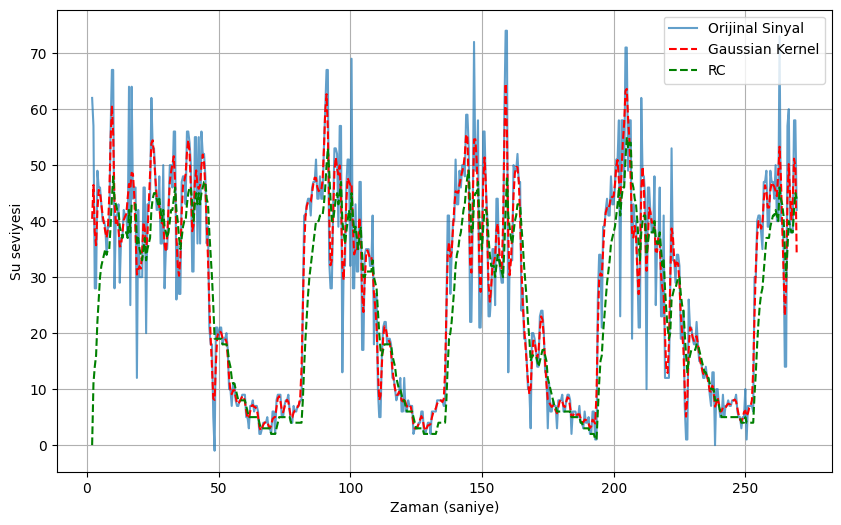

In [204]:
from scipy.signal.windows import gaussian

def RCFilter(signal, tau):
    filtered_signal = np.zeros_like(signal)
    for i in range(1, len(signal)):
        dV = (1 / tau) * (signal[i] - filtered_signal[i - 1])
        filtered_signal[i] = filtered_signal[i - 1] + dV
    return filtered_signal

input = dataDict["S1"].values.squeeze()
t = time.iloc[shift:].values.squeeze()

kernel = gaussian(5, 1)
kernel /= kernel.sum()
gaus_f_S1 = np.convolve(input, kernel, mode='same')
rc_f_S1 = RCFilter(input, 5)

dataDict["gaus_f_S1"] = pd.DataFrame(gaus_f_S1)
# dataDict["gaus_f_S1"].iloc[0:20] = dataDict["gaus_f_S1"].iloc[20:40]
dataDict["rc_f_S1"] = pd.DataFrame(rc_f_S1)
# dataDict["rc_f_S1"].iloc[0:20] = dataDict["rc_f_S1"].iloc[20:40]

# Sonuçları grafikle görselleştirin
plt.figure(figsize=(10, 6))
plt.plot(t, input, label='Orijinal Sinyal', alpha=0.7)
plt.plot(t, gaus_f_S1, label='Gaussian Kernel', linestyle='--', color="red")
plt.plot(t, rc_f_S1, label='RC', linestyle='--', color="green")
plt.xlabel('Zaman (saniye)')
plt.ylabel('Su seviyesi')
plt.legend()
plt.grid()
plt.show()


<Axes: >

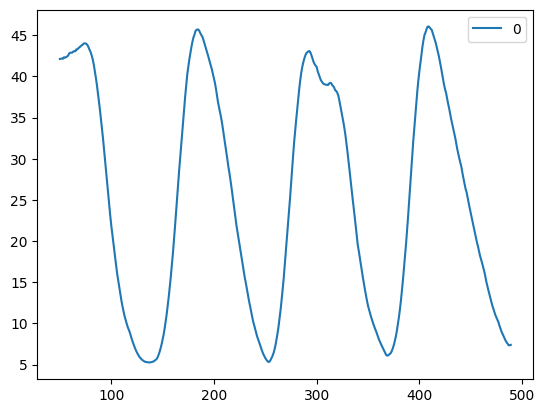

In [18]:
dataDict["gaus_f_S1"].iloc[50:-50].plot()
dataDict["]

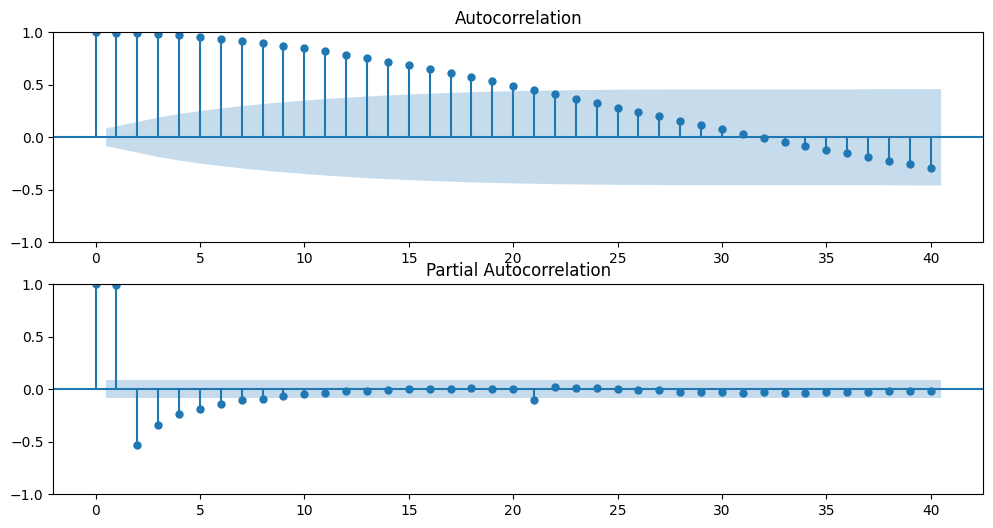

In [86]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
sm.graphics.tsa.plot_acf(dataDict["gaus_f_S1"], lags=40, ax=ax1)
sm.graphics.tsa.plot_pacf(dataDict["gaus_f_S1"], lags=40, ax=ax2)
plt.show()

In [25]:
from statsmodels.tsa.stattools import adfuller
adftest = adfuller(dataDict["S1"])
print(adftest[1])

0.003950621813185675


<Axes: >

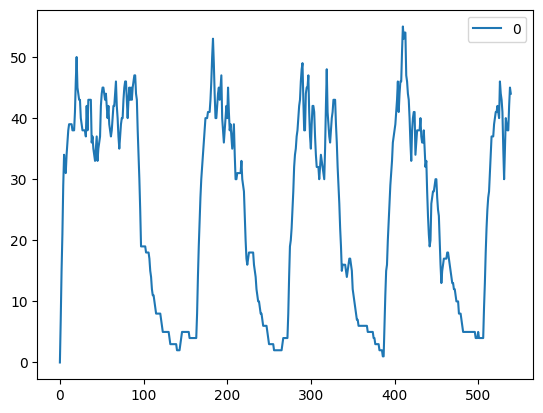

In [45]:
dataDict["rc_f_S1"].plot()

In [13]:
import pmdarima as pm

In [35]:
x = pm.auto_arima(dataDict["gaus_f_S1"].iloc[10:-10],dataDict["gate1"].iloc[10:-10], seasonal=False)

In [47]:
dataDict["gate1"].shift(10)

,0
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
535,60.0
536,60.0
537,60.0
538,60.0


In [33]:
model = sm.tsa.ARIMA(dataDict["gaus_f_S1"].iloc[10:-10], exog=dataDict["gate1"].iloc[10:-10], order=(2,0,2))
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      0   No. Observations:                  520
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -1065.667
Date:                Thu, 02 Nov 2023   AIC                           2145.335
Time:                        00:25:54   BIC                           2175.112
Sample:                             0   HQIC                          2157.000
                                - 520                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.7888     82.594     -0.131      0.896    -172.669     151.092
0             -0.0013      0.001     -1.128      0.259      -0.004       0.001
ar.L1          1.0464      0.041     25.743      0.0

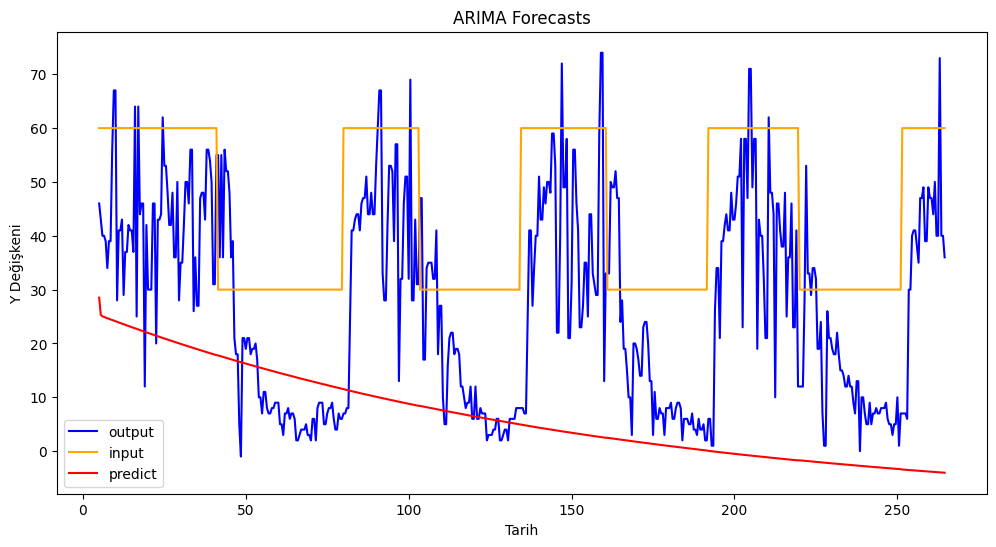

In [34]:
trim = 10
# forecast = results.predict(start=i, exog=dataDict["gate1"], end=j, dynamic=False)
forecast = results.forecast(len(dataDict["gate1"].iloc[trim:-trim]), exog=dataDict["gate1"].iloc[trim:-trim])

plt.figure(figsize=(12, 6))
plt.plot(dataDict["t"].iloc[trim:-trim], dataDict["S1"].iloc[trim:-trim], label='output', color='blue')
plt.plot(dataDict["t"].iloc[trim:-trim], dataDict["gate1"].iloc[trim:-trim], label='input', color='orange')
plt.plot(dataDict["t"].iloc[trim:-trim], forecast, label='predict', color='red')
plt.legend()
plt.title('ARIMA Forecasts')
plt.xlabel('Tarih')
plt.ylabel('Y Değişkeni')
plt.show()


In [100]:
dataDict["gate1"].iloc[5:]

,0
5,60
6,60
7,60
8,60
9,60
...,...
535,60
536,60
537,60
538,60


In [103]:
dataDict["gate1"].iloc[10:]

,0
10,60
11,60
12,60
13,60
14,60
...,...
535,60
536,60
537,60
538,60


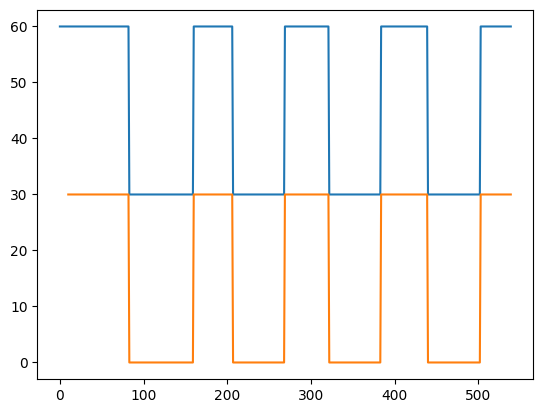

In [102]:
plt.plot(dataDict["gate1"])
plt.plot(dataDict["gate1"].iloc[10:]-30)

In [ ]:
p_values = range(0, 10)
q_values = range(0, 10)
i_values = range(0, 1)

best_aic = float("inf")
best_order = (0, 0, 0)

for p in p_values:
    for q in q_values:
        print(p, q)
        try:
            model = sm.tsa.ARIMA(dataDict["gaus_f_S1"], exog=dataDict["gate1"], order=(p, i, q))
            results = model.fit()
            aic = results.aic
            if aic < best_aic:
                best_aic = aic
                best_order = (p, i, q)
        except:
            continue

print(f'Best AIC: {best_aic}')
print(f'Best Order: {best_order}')

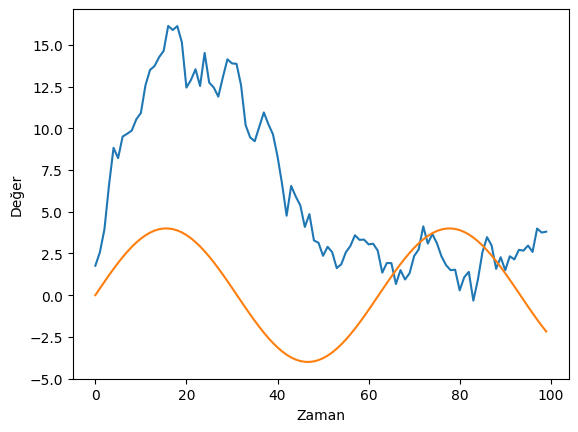

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA

# Zaman serisi verisini oluşturalım (örnek veri)
np.random.seed(0)
n = 100

input = np.sin(np.linspace(0, 10, n))*4
time_series_data = np.cumsum(np.random.normal(0, 1, n)) + input

data = {"input" : input,
    "value": time_series_data}
# Zaman serisini bir Pandas DataFrame'e dönüştürelim
time_series_df = pd.DataFrame(data)

# Zaman serisini görselleştirelim
plt.plot(time_series_df['value'])
plt.plot(time_series_df['input'])
plt.xlabel('Zaman')
plt.ylabel('Değer')
plt.show()


In [37]:
# ARIMA modelini oluşturalım ve uyarlayalım
model = sm.tsa.ARIMA(time_series_df['value'], exog=time_series_df['input'], order=(1, 1, 1))
model_fit = model.fit()

# Modelin özetini görüntüleyelim
print(model_fit.summary())

forecast = model_fit.predict(start=0, exog=data["input"].iloc[i:j], end=10, dynamic=False)

# Tahminleri ve gerçek verileri karşılaştıralım
plt.plot(time_series_df['value'], label='Gerçek Veri')
plt.plot(model_fit.fittedvalues, color='red', label='Tahmin')
plt.legend()
plt.xlabel('Zaman')
plt.ylabel('Değer')
plt.show()


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  100
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -138.905
Date:                Mon, 30 Oct 2023   AIC                            285.810
Time:                        02:20:34   BIC                            296.191
Sample:                             0   HQIC                           290.010
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
input          0.7326      0.463      1.581      0.114      -0.176       1.641
ar.L1          0.9444      0.091     10.419      0.000       0.767       1.122
ma.L1         -0.8873      0.125     -7.105      0.0

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'